In [1]:
%matplotlib inline

# Import library

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn

# Data Splitting
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

# Encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# Cross Validation
from sklearn.model_selection import cross_validate, cross_val_score

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Metrics Evaluation
from sklearn.metrics import (make_scorer, confusion_matrix, fbeta_score, 
                                ConfusionMatrixDisplay, classification_report, precision_recall_curve, auc)
from sklearn.model_selection import StratifiedKFold

# interpretasi
import shap
from lightgbm import plot_importance

# save model
import pickle

import time
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate

# Load Dataset

In [3]:
df = pd.read_csv('data_bank_marketing_campaign.csv')
df

age            job  balance housing loan    contact month  campaign  \
0      55         admin.     1662      no   no   cellular   jun         2   
1      39  self-employed    -3058     yes  yes   cellular   apr         3   
2      51         admin.     3025      no   no   cellular   may         1   
3      38       services      -87     yes   no   cellular   may         1   
4      36      housemaid      205     yes   no  telephone   nov         4   
...   ...            ...      ...     ...  ...        ...   ...       ...   
7808   62      housemaid        2      no   no   cellular   nov         1   
7809   48      housemaid     5473      no   no   cellular   feb         2   
7810   36        unknown      179      no   no   cellular   aug         8   
7811   31         admin.       54     yes   no   cellular   nov         1   
7812   60        retired     1588      no   no   cellular   oct         1   

      pdays poutcome deposit  
0        -1  unknown     yes  
1        -1  unknown     yes  
2       352    other     yes  
3        -1  unknown      no  
4        -1  unknown      no  
...     ...      ...     ...  
7808     -1  unknown     yes  
7809    184  success     yes  
7810     -1  unknown      no  
7811     -1  unknown      no  
7812     -1  unknown     yes  

[7813 rows x 11 columns]

# Introduction

## Context
Dataset berisikan kampanye pemasaran oleh sebuah bank yang menawarkan produk deposit berjangka. Setiap baris merepresentasikan satu calon nasabah yang dihubungi oleh tim marketing, dengan informasi terkait karakteristik pribadi (usia, pekerjaan), informasi ekonomi (saldo, pinjaman, perumahan, dll), serta hasil panggilan sebelumnya. Tujuan dari dataset ini adalah untuk memahami karakteristik dan perilaku nasabah yang cenderung melakukan deposit.

## Bussines Problem
Tim marketing memiliki keterbatasan sumber daya (tenaga dan waktu) dalam melakukan panggilan promosi. Tanpa model prediksi, setiap calon nasabah dihubungi secara acak yang dapat menyebabkan banyak panggilan tidak menghasilkan konversi (nasabah tidak tertarik untuk melakukan deposit).

Masalah bisnis utamanya adalah:
"Bagaimana mengurangi jumlah panggilan yang tidak efektif tanpa menurunkan jumlah nasabah yang melakukan deposit?"

## Goals
Tujuan analisis ini adalah membangun model machine learning yang mampu:

1. Memprediksi apakah calon nasabah akan melakukan deposit setelah dihubungi.

2. Membantu tim marketing menargetkan panggilan hanya kepada calon nasabah yang berpotensi tinggi untuk konversi.

3. Mengukur seberapa besar penghematan biaya operasional yang dapat dicapai dengan menggunakan model dibandingkan tanpa model.

## Analytical Approach
1. Melakukan pembersihan dan praproses data, termasuk encoding variabel kategorikal dan transformasi numerik menggunakan scaling dan tanpa scaling.

2. Membangun pipeline dengan dua model utama:
    - Baseline model: Memilih salah satu dari 7 model.
    - Tuned model: menggunakan baseline model terbaik dengan optimasi hyperparameter.

3. Melakukan pembagian data train dan test.

4. Mengevaluasi performa model dengan metrik utama F1-score, karena metrik ini menyeimbangkan precision dan recall.
    - Precision = seberapa banyak nasabah yang benar deposit dari semua jumlah nasabah yang diprediksi akan deposit oleh model.
    - Recall = seberapa banyak calon nasabah melakukan deposit yang berhasil ditangkap model.

5. Mengevaluasi hasil dengan confusion matrix, precision-recall curve, Classification Report dan SHAP values untuk interpretabilitas.

## Stakeholder
- Tim Marketing: ingin tahu calon nasabah mana yang harus dihubungi pekerjaan lebih efisien.

- Manajemen Keuangan: berfokus pada efisiensi biaya operasional dan peningkatan rasio konversi.

- Data Analyst/Data Scientist: bertanggung jawab untuk membangun model prediktif dan menjelaskan hasilnya dalam konteks bisnis.

## metric selection
Stakeholder ingin menekan dua jenis kesalahan:
- False Positive (FP): menelepon orang yang ternyata tidak tertarik yang membuat biaya operasional meningkat.
- False Negative (FN): tidak menelepon orang yang sebenarnya tertarik yang mengakibatkan kehilangan peluang pendapatan.

Keduanya merugikan, sehingga F1-score digunakan sebagai metrik utama karena menyeimbangkan precision untuk menghindari FP dan recall untuk menghindari FN.

## 5-point business ML goals
| **Elemen**        | **Penjelasan**                                                                   |
| ----------------- | -------------------------------------------------------------------------------- |
| **Problem**       | Banyak panggilan marketing tidak efektif, menyebabkan pemborosan biaya.          |
| **Data**          | Data historis kampanye pemasaran (demografi, status ekonomi, hasil panggilan).   |
| **ML Objectives** | Memprediksi kemungkinan nasabah akan melakukan deposit.                          |
| **Action**        | Prioritaskan panggilan hanya pada calon dengan probabilitas tinggi deposit.      |
| **Value**         | Menghemat biaya operasional telemarketing dan meningkatkan efektivitas kampanye. |


## Cost Assumption
- Biaya panggilan: Rp100.000
- Keuntungan Konversi: Rp300.000
- TP: Rp300.000
- TN: Rp100.000
- FP: (-Rp100.000)
- FN: (-Rp150.000) kerugian potensi

# Data understanding

## Data Dictionary
- age        : Umur nasabah
- job        : Jenis pekerjaan
- balance    : Rata-rata saldo
- housing    : Status pinjaman rumah
- loan       : Status pinjaman pribadi
- contact    : Jenis kontak komunikasi
- month      : Bulan kontak terakhir
- campaign   : Jumlah kontak selama campaign
- pdays      : Jumlah hari sejak kontak terakhir
- poutcome   : Hasil campaign sebelumnya
- deposit    : Target (yes/no)

## EDA

### Auto EDA

In [4]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title='Pandas profiling report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 198.01it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Duplicated Data

In [5]:
df = df.drop_duplicates()

In [6]:
df.duplicated().sum()

np.int64(0)

### Melihat nilai ourlier

#### Outlier kolom kategori

Unknown kolom poutcome

In [7]:
df['poutcome'].value_counts(normalize=True)*100

poutcome
unknown    74.452274
failure    10.864830
success     9.750160
other       4.932735
Name: proportion, dtype: float64

In [8]:
# cross table contact and pdays
pd.crosstab(df['poutcome'], df['pdays'] == -1)

pdays     False  True 
poutcome              
failure     848      0
other       385      0
success     761      0
unknown       2   5809

In [9]:
df[ (df['poutcome']=='unknown')]

age            job  balance housing loan    contact month  campaign  \
0      55         admin.     1662      no   no   cellular   jun         2   
1      39  self-employed    -3058     yes  yes   cellular   apr         3   
3      38       services      -87     yes   no   cellular   may         1   
4      36      housemaid      205     yes   no  telephone   nov         4   
5      41         admin.      -76     yes   no   cellular   apr         1   
...   ...            ...      ...     ...  ...        ...   ...       ...   
7807   33     management        0     yes  yes   cellular   may         2   
7808   62      housemaid        2      no   no   cellular   nov         1   
7810   36        unknown      179      no   no   cellular   aug         8   
7811   31         admin.       54     yes   no   cellular   nov         1   
7812   60        retired     1588      no   no   cellular   oct         1   

      pdays poutcome deposit  
0        -1  unknown     yes  
1        -1  unknown     yes  
3        -1  unknown      no  
4        -1  unknown      no  
5        -1  unknown      no  
...     ...      ...     ...  
7807     -1  unknown      no  
7808     -1  unknown     yes  
7810     -1  unknown      no  
7811     -1  unknown      no  
7812     -1  unknown     yes  

[5811 rows x 11 columns]

kita dapat berasumsi bahwa data poutcome bisa unknown dikarenakan nilai pdays yang -1, berarti pelanggan tersebut tidak dihubungi melalui campaign

In [10]:
df[ (df['poutcome']=='unknown') & (df['pdays'] == -1)]

age            job  balance housing loan    contact month  campaign  \
0      55         admin.     1662      no   no   cellular   jun         2   
1      39  self-employed    -3058     yes  yes   cellular   apr         3   
3      38       services      -87     yes   no   cellular   may         1   
4      36      housemaid      205     yes   no  telephone   nov         4   
5      41         admin.      -76     yes   no   cellular   apr         1   
...   ...            ...      ...     ...  ...        ...   ...       ...   
7807   33     management        0     yes  yes   cellular   may         2   
7808   62      housemaid        2      no   no   cellular   nov         1   
7810   36        unknown      179      no   no   cellular   aug         8   
7811   31         admin.       54     yes   no   cellular   nov         1   
7812   60        retired     1588      no   no   cellular   oct         1   

      pdays poutcome deposit  
0        -1  unknown     yes  
1        -1  unknown     yes  
3        -1  unknown      no  
4        -1  unknown      no  
5        -1  unknown      no  
...     ...      ...     ...  
7807     -1  unknown      no  
7808     -1  unknown     yes  
7810     -1  unknown      no  
7811     -1  unknown      no  
7812     -1  unknown     yes  

[5809 rows x 11 columns]

In [11]:
df[ (df['poutcome']=='unknown') & (df['pdays'] != -1)]

age      job  balance housing loan   contact month  campaign  pdays  \
2849   61  retired     3140     yes  yes  cellular   aug         4     98   
3983   26   admin.      338      no   no  cellular   oct         1    188   

     poutcome deposit  
2849  unknown     yes  
3983  unknown     yes

In [12]:
# Drop kolom yang poutcome unknown tapi pdays > -1
df = df.drop(df[ (df['poutcome']=='unknown') & (df['pdays'] != -1)].index)

In [13]:
df[ (df['poutcome']=='unknown') & (df['pdays'] != -1)]

Empty DataFrame
Columns: [age, job, balance, housing, loan, contact, month, campaign, pdays, poutcome, deposit]
Index: []

Unknown kolom Contact

In [14]:
df['contact'].value_counts(normalize=True)*100

contact
cellular     72.036396
unknown      20.966295
telephone     6.997309
Name: proportion, dtype: float64

In [15]:
# cross table contact dan pdays
pd.crosstab(df['contact'], df['pdays'] == -1)

pdays      False  True 
contact                
cellular    1839   3782
telephone    139    407
unknown       16   1620

In [16]:
df[ (df['contact']=='unknown') & (df['pdays'] == -1)]

age          job  balance housing loan  contact month  campaign  pdays  \
9      57    housemaid        0      no   no  unknown   jun         1     -1   
16     39  blue-collar      169     yes   no  unknown   may         1     -1   
29     44  blue-collar     1025     yes   no  unknown   jun         1     -1   
33     28       admin.      785     yes   no  unknown   may         2     -1   
34     42   management      742     yes   no  unknown   may         3     -1   
...   ...          ...      ...     ...  ...      ...   ...       ...    ...   
7774   44  blue-collar      776     yes   no  unknown   may         1     -1   
7780   39   unemployed     1654      no   no  unknown   jun         6     -1   
7781   26   management      775      no   no  unknown   may         3     -1   
7792   57       admin.     4168     yes  yes  unknown   may         1     -1   
7795   41   technician      102     yes  yes  unknown   may         9     -1   

     poutcome deposit  
9     unknown      no  
16    unknown      no  
29    unknown      no  
33    unknown     yes  
34    unknown      no  
...       ...     ...  
7774  unknown      no  
7780  unknown      no  
7781  unknown      no  
7792  unknown      no  
7795  unknown      no  

[1620 rows x 11 columns]

In [17]:
df[ (df['contact']=='unknown') & (df['pdays'] != -1)]

age          job  balance housing loan  contact month  campaign  pdays  \
126    53     services       36     yes  yes  unknown   jul         1    417   
399    31  blue-collar        0     yes   no  unknown   aug         1    782   
828    34       admin.      899     yes   no  unknown   nov         1    170   
1120   32   management      302     yes  yes  unknown   feb         1    384   
1324   27  blue-collar      821     yes  yes  unknown   sep         1    778   
1450   44   technician      314     yes   no  unknown   aug         1    651   
1634   56   technician      589     yes   no  unknown   oct         1    147   
1995   36  blue-collar     3623      no   no  unknown   nov         1    378   
2235   29       admin.     1070     yes   no  unknown   may         1    357   
3165   35   management     1120      no   no  unknown   sep         1    771   
3265   29  blue-collar      322      no   no  unknown   jun         1     96   
3541   39   unemployed      265     yes   no  unknown   may         1    555   
5092   45       admin.      375      no  yes  unknown   sep         1    594   
5179   47   technician     1233     yes   no  unknown   sep         1    100   
5768   36   management      335      no   no  unknown   oct         1    772   
7216   52   management     1708      no   no  unknown   sep         1     75   

     poutcome deposit  
126   success     yes  
399     other     yes  
828   failure     yes  
1120  failure     yes  
1324    other      no  
1450  success      no  
1634  success     yes  
1995  success     yes  
2235    other     yes  
3165  success      no  
3265    other     yes  
3541    other     yes  
5092  failure      no  
5179    other     yes  
5768  failure      no  
7216  failure     yes

- Contact bisa unknown jika pdays -1, di mana pelanggan belum pernah dihubungi
- Untuk contact unknown dengan pdays >-1 akan diubah menjadi others

In [18]:
df.loc[(df['contact'].str.strip() == 'unknown') & (df['pdays'] > -1), 'contact'] = 'other'

In [19]:
# cek unknown dan pdays >-1
df[((df['contact']=='unknown')& (df['pdays'] != -1))]

Empty DataFrame
Columns: [age, job, balance, housing, loan, contact, month, campaign, pdays, poutcome, deposit]
Index: []

In [20]:
df[ (df['contact']=='other')]

age          job  balance housing loan contact month  campaign  pdays  \
126    53     services       36     yes  yes   other   jul         1    417   
399    31  blue-collar        0     yes   no   other   aug         1    782   
828    34       admin.      899     yes   no   other   nov         1    170   
1120   32   management      302     yes  yes   other   feb         1    384   
1324   27  blue-collar      821     yes  yes   other   sep         1    778   
1450   44   technician      314     yes   no   other   aug         1    651   
1634   56   technician      589     yes   no   other   oct         1    147   
1995   36  blue-collar     3623      no   no   other   nov         1    378   
2235   29       admin.     1070     yes   no   other   may         1    357   
3165   35   management     1120      no   no   other   sep         1    771   
3265   29  blue-collar      322      no   no   other   jun         1     96   
3541   39   unemployed      265     yes   no   other   may         1    555   
5092   45       admin.      375      no  yes   other   sep         1    594   
5179   47   technician     1233     yes   no   other   sep         1    100   
5768   36   management      335      no   no   other   oct         1    772   
7216   52   management     1708      no   no   other   sep         1     75   

     poutcome deposit  
126   success     yes  
399     other     yes  
828   failure     yes  
1120  failure     yes  
1324    other      no  
1450  success      no  
1634  success     yes  
1995  success     yes  
2235    other     yes  
3165  success      no  
3265    other     yes  
3541    other     yes  
5092  failure      no  
5179    other     yes  
5768  failure      no  
7216  failure     yes

mencari unknown di kolom job

In [21]:
df['job'].value_counts(normalize=True)*100

job
management       22.927079
blue-collar      17.211329
technician       16.519287
admin.           11.982571
services          8.432654
retired           6.907600
self-employed     3.588363
unemployed        3.191080
student           3.165449
entrepreneur      3.024478
housemaid         2.358067
unknown           0.692042
Name: proportion, dtype: float64

In [22]:
# crosstab
pd.crosstab(df['job'], df['pdays'] == -1)

pdays          False  True 
job                        
admin.           274    661
blue-collar      259   1084
entrepreneur      40    196
housemaid         30    154
management       513   1276
retired          177    362
self-employed     71    209
services         137    521
student           99    148
technician       309    980
unemployed        71    178
unknown           14     40

In [23]:
df[ (df['job']=='unknown') & (df['pdays'] == -1)]

age      job  balance housing loan    contact month  campaign  pdays  \
103    45  unknown      356      no   no   cellular   aug         2     -1   
110    41  unknown     1567      no   no   cellular   jul         2     -1   
332    48  unknown        3      no   no   cellular   aug         2     -1   
902    60  unknown    17297      no   no   cellular   aug        11     -1   
981    57  unknown    19268      no   no    unknown   oct         1     -1   
1039   58  unknown     1547      no   no  telephone   aug         4     -1   
1073   48  unknown      558      no   no   cellular   aug         6     -1   
1142   53  unknown      549      no   no  telephone   jan         2     -1   
1230   26  unknown     3247      no   no  telephone   feb         3     -1   
1543   30  unknown     6929      no   no   cellular   nov         1     -1   
1844   54  unknown      390      no   no   cellular   aug         5     -1   
2220   47  unknown     1880      no   no    unknown   jun         2     -1   
2223   45  unknown       44      no   no    unknown   jun         1     -1   
2251   45  unknown      406      no   no   cellular   sep         1     -1   
2272   49  unknown      341     yes  yes    unknown   may         2     -1   
2372   53  unknown        0      no   no   cellular   aug         5     -1   
2436   42  unknown      222      no   no   cellular   aug        16     -1   
3087   65  unknown     4717      no   no  telephone   aug         1     -1   
3186   41  unknown      942      no   no   cellular   apr         1     -1   
3362   39  unknown        0      no   no  telephone   jan         1     -1   
3506   31  unknown        3      no   no   cellular   jul         2     -1   
3734   52  unknown     5361      no   no   cellular   aug         3     -1   
3921   37  unknown        0      no   no   cellular   mar         1     -1   
4148   53  unknown      732      no   no   cellular   oct         2     -1   
4221   41  unknown      779      no   no   cellular   jul        10     -1   
4478   78  unknown     2235      no   no  telephone   apr         3     -1   
4607   59  unknown     2443      no   no    unknown   jun         8     -1   
4743   35  unknown      634      no   no   cellular   jul         2     -1   
5007   28  unknown     4465      no   no   cellular   jan         1     -1   
5035   54  unknown      895      no   no   cellular   oct         1     -1   
5071   47  unknown      194      no   no   cellular   aug         1     -1   
5170   59  unknown     3237      no   no    unknown   jun         3     -1   
5991   77  unknown      397      no   no  telephone   may         3     -1   
6065   58  unknown       68      no   no   cellular   apr         1     -1   
6445   59  unknown     1541      no   no   cellular   aug         1     -1   
6496   67  unknown     7687      no   no  telephone   oct         3     -1   
6983   43  unknown     1517      no   no    unknown   jun         1     -1   
7101   59  unknown       27      no   no    unknown   may         3     -1   
7495   31  unknown      526      no   no   cellular   aug        13     -1   
7810   36  unknown      179      no   no   cellular   aug         8     -1   

     poutcome deposit  
103   unknown      no  
110   unknown      no  
332   unknown      no  
902   unknown     yes  
981   unknown     yes  
1039  unknown     yes  
1073  unknown      no  
1142  unknown      no  
1230  unknown      no  
1543  unknown      no  
1844  unknown      no  
2220  unknown      no  
2223  unknown      no  
2251  unknown     yes  
2272  unknown     yes  
2372  unknown      no  
2436  unknown      no  
3087  unknown     yes  
3186  unknown     yes  
3362  unknown      no  
3506  unknown      no  
3734  unknown     yes  
3921  unknown     yes  
4148  unknown     yes  
4221  unknown      no  
4478  unknown     yes  
4607  unknown      no  
4743  unknown      no  
5007  unknown     yes  
5035  unknown     yes  
5071  unknown      no  
5170  unknown      no  
5991  unknown  

In [24]:
df[ (df['job']=='unknown') & (df['pdays'] != -1)]

age      job  balance housing loan    contact month  campaign  pdays  \
1079   55  unknown     2206      no   no   cellular   aug         1     91   
3533   31  unknown      111      no   no   cellular   nov         2     93   
4417   27  unknown     1187      no   no  telephone   feb         1    101   
5348   50  unknown      341     yes  yes   cellular   apr         4    340   
5748   46  unknown     8564      no   no   cellular   aug         2    342   
5808   37  unknown        0      no   no   cellular   jun         2     97   
6201   38  unknown        0      no   no   cellular   sep         3     95   
6322   55  unknown     1157      no   no   cellular   jul         1    412   
6463   50  unknown      558      no   no   cellular   jul         1    683   
6772   47  unknown      677      no   no   cellular   apr         2     86   
6845   77  unknown      397      no   no  telephone   nov         1    185   
7009   42  unknown      942      no   no   cellular   jan         1     92   
7203   54  unknown     2206      no   no   cellular   may         1     91   
7324   33  unknown      335      no   no   cellular   feb         2    177   

     poutcome deposit  
1079  success     yes  
3533  failure     yes  
4417  failure     yes  
5348  success     yes  
5748  failure      no  
5808  success     yes  
6201  success     yes  
6322  failure      no  
6463  failure     yes  
6772  failure     yes  
6845  success      no  
7009  success     yes  
7203  success     yes  
7324  failure     yes

- job bisa unknown jika pdays -1, di mana pelanggan belum pernah dihubungi
- Untuk job unknown dengan pdays >-1 akan diubah menjadi others

In [25]:
df.loc[(df['job'].str.strip() == 'unknown') & (df['pdays'] > -1), 'job'] = 'other'

In [26]:
df[ (df['job']=='unknown') & (df['pdays'] != -1)]

Empty DataFrame
Columns: [age, job, balance, housing, loan, contact, month, campaign, pdays, poutcome, deposit]
Index: []

In [27]:
df[df['job']=='other']

age    job  balance housing loan    contact month  campaign  pdays  \
1079   55  other     2206      no   no   cellular   aug         1     91   
3533   31  other      111      no   no   cellular   nov         2     93   
4417   27  other     1187      no   no  telephone   feb         1    101   
5348   50  other      341     yes  yes   cellular   apr         4    340   
5748   46  other     8564      no   no   cellular   aug         2    342   
5808   37  other        0      no   no   cellular   jun         2     97   
6201   38  other        0      no   no   cellular   sep         3     95   
6322   55  other     1157      no   no   cellular   jul         1    412   
6463   50  other      558      no   no   cellular   jul         1    683   
6772   47  other      677      no   no   cellular   apr         2     86   
6845   77  other      397      no   no  telephone   nov         1    185   
7009   42  other      942      no   no   cellular   jan         1     92   
7203   54  other     2206      no   no   cellular   may         1     91   
7324   33  other      335      no   no   cellular   feb         2    177   

     poutcome deposit  
1079  success     yes  
3533  failure     yes  
4417  failure     yes  
5348  success     yes  
5748  failure      no  
5808  success     yes  
6201  success     yes  
6322  failure      no  
6463  failure     yes  
6772  failure     yes  
6845  success      no  
7009  success     yes  
7203  success     yes  
7324  failure     yes

In [28]:
# Unique value checking
pd.set_option('display.max_colwidth', 0)
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

Column Name  Number of Unique  \
0   age         75                 
1   job         13                 
2   balance     3153               
3   housing     2                  
4   loan        2                  
5   contact     4                  
6   month       12                 
7   campaign    32                 
8   pdays       422                
9   poutcome    4                  
10  deposit     2                  

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Unique Sample  
0   [55, 39, 51, 38, 36, 41, 37, 35, 57, 23, 33, 31, 53, 30, 46, 48, 25, 29, 28, 52, 49, 44, 42, 27, 47, 64, 26, 34, 56, 32, 58, 45, 54, 50, 79, 65, 40, 24, 60, 43, 61, 59, 62, 68, 82, 71, 73, 76, 69, 20, 72, 22, 67, 19, 70, 75, 63, 93, 77, 80, 66, 21, 87, 81, 92, 88, 84, 83, 78, 74, 18, 85, 95, 86, 90]                                                                                                                                                                                                                                           
1   [admin., self-employed, services, housemaid, technician, management, student, blue-collar, entrepreneur, retired, unemployed, unknown, other]                                                                                                                                                                                                                                                                                                                                                                                                          
2   [1662, -3058, 3025, -87, 205, -76, 4803, 911, 805, 0, 1234, 1107, 1170, 341, 4808, 88, 169, 863, 242, 2597, 4929, 277, 1438, 15, 3733, 204, 1684, 1025, 55, 19, 348, 785, 742, 511, 6651, 1612, 555, 54, 1185, 110, 950, 412, 228, 367, 3993, 2599, 3528, 32, 551, 3161, 533, 8725, 349, 514, 2688, -194, 154, 874, 2, 5953, 1269, -327, 235, 7, 2661, 1948, 20, 502, 193, 13658, 1716, 172, 1667, 157, 8, 951, 427, 241, 469, 2060, 7177, 655, -114, 588, -971, 4570, 250, 131, 93, 22, 15341, 356, 190, -124, 2228, -60, 376, 1567, 855, 4151, ...]  
3   [no, yes]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
4   [no, yes]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
5   [cellular, telephone, unknown, other]                                                                                                                                                                                                                                                                                                 

In [29]:
# Sudah deposit tapi balance 0
df[ (df['balance']== 0) & (df['deposit'] == 'yes')]

age         job  balance housing loan   contact month  campaign  pdays  \
23    35   management  0        yes     no   cellular  nov   2         96      
92    55   management  0        no      no   cellular  aug   4        -1       
143   45   technician  0        yes     no   cellular  dec   1        -1       
158   71   retired     0        no      no   cellular  feb   1         171     
164   28   management  0        yes     no   cellular  jul   5        -1       
...   ..          ... ..        ...     ..        ...  ...  ..        ..       
7683  22   student     0        no      no   cellular  feb   6        -1       
7691  54   admin.      0        no      no   cellular  jan   1        -1       
7740  49   services    0        yes     no   cellular  may   2         166     
7771  37   technician  0        yes     no   cellular  jul   6        -1       
7777  55   retired     0        no      no   cellular  aug   1        -1       

     poutcome deposit  
23    success  yes     
92    unknown  yes     
143   unknown  yes     
158   success  yes     
164   unknown  yes     
...       ...  ...     
7683  unknown  yes     
7691  unknown  yes     
7740  failure  yes     
7771  unknown  yes     
7777  unknown  yes     

[206 rows x 11 columns]

In [30]:
# cek data ada '.'
for col in df.select_dtypes(include='object').columns:
    mask = df[col].str.contains(r'\.', na=False)
    if mask.any():
        print(f'Kolom {col} punya titik di baris:')
        display(df.loc[mask, [col]])

Kolom job punya titik di baris:


job
0     admin.
2     admin.
5     admin.
6     admin.
27    admin.
...      ...
7789  admin.
7791  admin.
7792  admin.
7804  admin.
7811  admin.

[935 rows x 1 columns]

In [31]:
df['job'] = df['job'].str.replace(r'\.$', '', regex=True)

In [32]:
for col in df.select_dtypes(include='object').columns:
    mask = df[col].str.contains(r'\.', na=False)
    if mask.any():
        print(f'Kolom "{col}" punya titik di baris:')
        display(df.loc[mask, [col]])
    else:
        print(f'Tidak ada tanda titik di kolom {col}')

Tidak ada tanda titik di kolom job
Tidak ada tanda titik di kolom housing
Tidak ada tanda titik di kolom loan
Tidak ada tanda titik di kolom contact
Tidak ada tanda titik di kolom month
Tidak ada tanda titik di kolom poutcome
Tidak ada tanda titik di kolom deposit


In [33]:
# Check whitespace in column
obj_cols = df.select_dtypes(include=['object']).columns
for col in obj_cols:
    mask = df[col].str.match(r'\s') | df[col].str.match(r'.*\s$')
    if mask.any():
        print(f'\nWhitespaces in column {col}:')
        print(df.loc[mask, col].head())
    else:
        print(f'There are no whitespace in column {col}')

There are no whitespace in column job
There are no whitespace in column housing
There are no whitespace in column loan
There are no whitespace in column contact
There are no whitespace in column month
There are no whitespace in column poutcome
There are no whitespace in column deposit


#### Outlier kolom numerik

In [34]:
# mencari data string di kolom numerik
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    mask = df[col].apply(lambda x: isinstance(x, str))
    if mask.any():
        print(f'\nString values in numeric column {col}:')
        print(df.loc[mask, col].head())
    else:
        print(f'there are no string in numeric column {col}')

there are no string in numeric column age
there are no string in numeric column balance
there are no string in numeric column campaign
there are no string in numeric column pdays


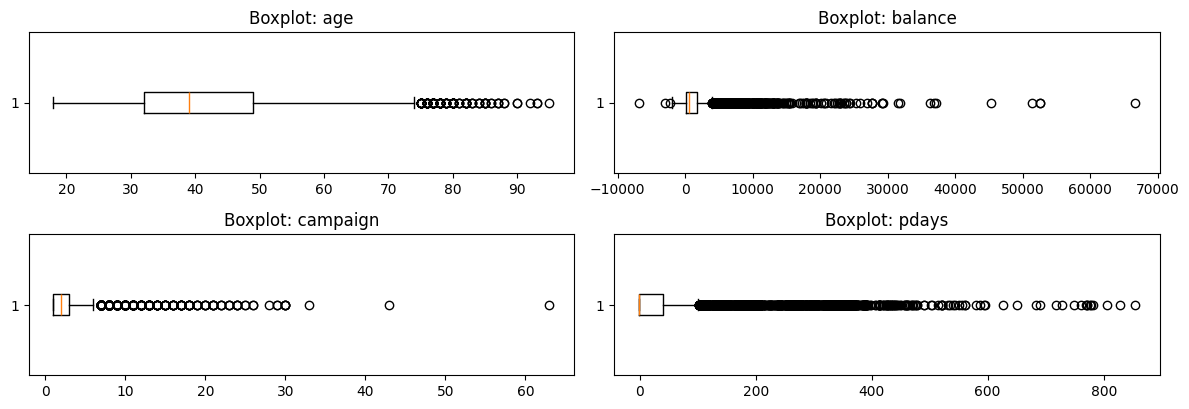

Rangkuman Outlier Tiap Kolom:


Kolom  Jumlah Outlier  Persentase (%)  Nilai Minimum  Nilai Maksimum  \
3  pdays     1453            18.62          -1              854              
1  balance   736             9.43           -6847           66653            
2  campaign  429             5.50            1              63               
0  age       121             1.55            18             95               

   Batas Bawah  Batas Atas  
3 -62.5         101.5       
1 -2207.5       4020.5      
2 -2.0          6.0         
0  6.5          74.5

In [35]:
# Cek Outlier data yang numeric

outlier_summary = []

for col in num_cols:
    data = df[col].dropna()
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    outliers = data[(data < lower) | (data > upper)]
    n_outliers = len(outliers)
    
    outlier_summary.append({
        'Kolom': col,
        'Jumlah Outlier': n_outliers,
        'Persentase (%)': round((n_outliers / len(data)) * 100, 2),
        'Nilai Minimum': data.min(),
        'Nilai Maksimum': data.max(),
        'Batas Bawah': lower,
        'Batas Atas': upper
    })

plt.figure(figsize=(12, len(num_cols)*2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 2, i)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

# Data outlier masukin ke df dan perlihatkan pakai display sebagai rangkiman
outlier_df = pd.DataFrame(outlier_summary)
print('Rangkuman Outlier Tiap Kolom:')
display(outlier_df.sort_values('Jumlah Outlier', ascending=False))

### Mendeteksi Imbalance

In [36]:
df['deposit'].value_counts()

deposit
no     4075
yes    3728
Name: count, dtype: int64

In [37]:
# Cek proporsi target (deposit)
df['deposit'].value_counts(normalize=True)*100

deposit
no     52.223504
yes    47.776496
Name: proportion, dtype: float64

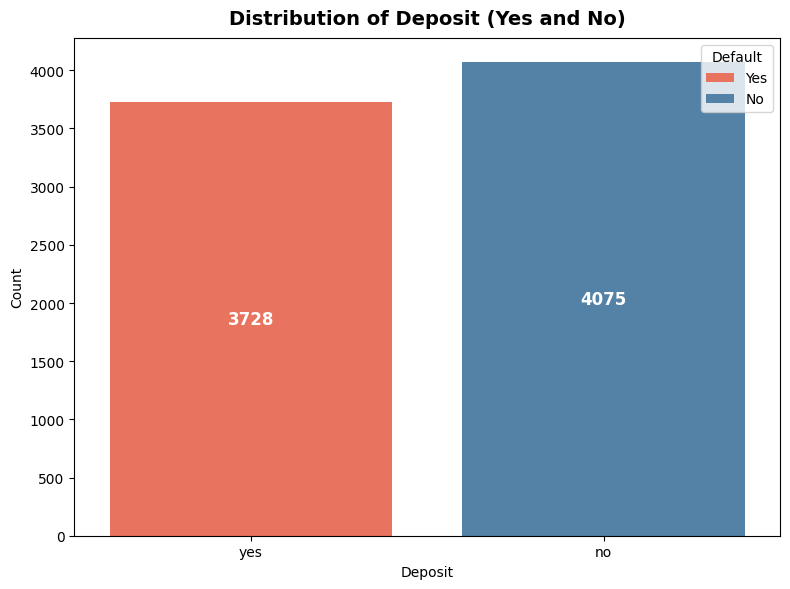

In [38]:
# Set custom color palette
custom_palette = {'yes': '#FF6347', 'no': '#4682B4'}

# Create the countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='deposit', hue='deposit', palette=custom_palette)

# Set labels and title
plt.xlabel('Deposit')
plt.ylabel('Count')
plt.title('Distribution of Deposit (Yes and No)', pad=10, fontsize=14, fontweight='bold')

# Set legend labels
plt.legend(labels=['Yes', 'No'], title='Default', loc='upper right')

# Adding annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    annotation = '{:.0f}'.format(height)

    if height != 0:
        if height < ax.get_ylim()[1] * 0.05:
            ax.annotate(annotation, (x + width / 2, height), ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
        else:
            ax.annotate(annotation, (x + width / 2, y + height / 2), ha='center', va='center', fontsize=12, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

### columns/features summary

In [39]:
# cek dtype tiap kolom dalam tabel pakai tabulate
dtype_summary = [
    (col, str(dtype), 'Target' if col.lower() == 'deposit' else 'Feature')
    for col, dtype in df.dtypes.items()
]
print(tabulate(dtype_summary, headers=['Column Name', 'Data Type', 'Role'], tablefmt='fancy_grid'))

╒═══════════════╤═════════════╤═════════╕
│ Column Name   │ Data Type   │ Role    │
╞═══════════════╪═════════════╪═════════╡
│ age           │ int64       │ Feature │
├───────────────┼─────────────┼─────────┤
│ job           │ object      │ Feature │
├───────────────┼─────────────┼─────────┤
│ balance       │ int64       │ Feature │
├───────────────┼─────────────┼─────────┤
│ housing       │ object      │ Feature │
├───────────────┼─────────────┼─────────┤
│ loan          │ object      │ Feature │
├───────────────┼─────────────┼─────────┤
│ contact       │ object      │ Feature │
├───────────────┼─────────────┼─────────┤
│ month         │ object      │ Feature │
├───────────────┼─────────────┼─────────┤
│ campaign      │ int64       │ Feature │
├───────────────┼─────────────┼─────────┤
│ pdays         │ int64       │ Feature │
├───────────────┼─────────────┼─────────┤
│ poutcome      │ object      │ Feature │
├───────────────┼─────────────┼─────────┤
│ deposit       │ object      │ Ta

membuat kolom contacted untuk eksperimen

# Define X and Y

In [40]:
X = df.drop(columns='deposit')
y = df['deposit'].map({'yes':1, 'no':0})

# Data splitting

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,
                 y,
                 random_state=42,
                 test_size=0.2)

# Feature Engineering

In [42]:
df

age            job  balance housing loan    contact month  campaign  \
0     55   admin          1662     no      no   cellular   jun   2          
1     39   self-employed -3058     yes     yes  cellular   apr   3          
2     51   admin          3025     no      no   cellular   may   1          
3     38   services      -87       yes     no   cellular   may   1          
4     36   housemaid      205      yes     no   telephone  nov   4          
...   ..         ...      ...      ...     ..         ...  ...  ..          
7808  62   housemaid      2        no      no   cellular   nov   1          
7809  48   housemaid      5473     no      no   cellular   feb   2          
7810  36   unknown        179      no      no   cellular   aug   8          
7811  31   admin          54       yes     no   cellular   nov   1          
7812  60   retired        1588     no      no   cellular   oct   1          

      pdays poutcome deposit  
0    -1      unknown  yes     
1    -1      unknown  yes     
2     352    other    yes     
3    -1      unknown  no      
4    -1      unknown  no      
...  ..          ...  ..      
7808 -1      unknown  yes     
7809  184    success  yes     
7810 -1      unknown  no      
7811 -1      unknown  no      
7812 -1      unknown  yes     

[7803 rows x 11 columns]

## Pemisahan kolom numeric dan Category

In [43]:
num_cols = ['age', 'balance', 'campaign']
cat_cols = ['job', 'contact', 'month', 'poutcome', 'housing', 'loan']

## pipeline kolom

In [44]:
num_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
]).set_output(transform='pandas')

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
]).set_output(transform='pandas')

## Penggabungan pipeline

In [45]:
#preprocessor with scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ], remainder='passthrough'
).set_output(transform='pandas')

In [46]:
#preprocessor without scaling
preprocessor_noscal = ColumnTransformer(
	transformers=[
		('num', 'passthrough', num_cols),
		('cat', cat_transformer, cat_cols)
	], remainder='passthrough'
).set_output(transform='pandas')

In [47]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['age', 'balance', 'campaign']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['job', 'contact', 'month', 'poutcome',
                                  'housing', 'loan'])])

In [48]:
preprocessor_noscal

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', 'passthrough',
                                 ['age', 'balance', 'campaign']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['job', 'contact', 'month', 'poutcome',
                                  'housing', 'loan'])])

In [49]:
y_train.value_counts(normalize=True)*100

deposit
0    52.53124
1    47.46876
Name: proportion, dtype: float64

In [50]:
X_train_prep = preprocessor.fit_transform(X_train)
X_train_prep.head()

num__age  num__balance  num__campaign  cat__job_admin  \
2412 -0.235294 -0.321406      2.0            0.0              
4270  0.352941 -0.284345     -0.5            0.0              
3987 -0.352941 -0.325240      1.5            0.0              
3250 -0.294118 -0.182748      1.0            0.0              
3834  0.823529 -0.417891     -0.5            0.0              

      cat__job_blue-collar  cat__job_entrepreneur  cat__job_housemaid  \
2412  0.0                   0.0                    0.0                  
4270  1.0                   0.0                    0.0                  
3987  0.0                   0.0                    0.0                  
3250  0.0                   0.0                    0.0                  
3834  0.0                   1.0                    0.0                  

      cat__job_management  cat__job_other  cat__job_retired  ...  \
2412  0.0                  0.0             0.0               ...   
4270  0.0                  0.0             0.0               ...   
3987  1.0                  0.0             0.0               ...   
3250  0.0                  0.0             0.0               ...   
3834  0.0                  0.0             0.0               ...   

      cat__month_sep  cat__poutcome_failure  cat__poutcome_other  \
2412  0.0             0.0                    0.0                   
4270  0.0             0.0                    0.0                   
3987  0.0             0.0                    0.0                   
3250  0.0             0.0                    0.0                   
3834  0.0             0.0                    0.0                   

      cat__poutcome_success  cat__poutcome_unknown  cat__housing_no  \
2412  0.0                    1.0                    1.0               
4270  0.0                    1.0                    0.0               
3987  0.0                    1.0                    1.0               
3250  0.0                    1.0                    1.0               
3834  0.0                    1.0                    1.0               

      cat__housing_yes  cat__loan_no  cat__loan_yes  remainder__pdays  
2412  0.0               1.0           0.0           -1                 
4270  1.0               1.0           0.0           -1                 
3987  0.0               1.0           0.0           -1                 
3250  0.0               1.0           0.0           -1                 
3834  0.0               0.0           1.0           -1                 

[5 rows x 41 columns]

In [51]:
X_train_prep2 = preprocessor_noscal.fit_transform(X_train)
X_train_prep2.head()

num__age  num__balance  num__campaign  cat__job_admin  \
2412  34        47            6              0.0              
4270  44        105           1              0.0              
3987  32        41            5              0.0              
3250  33        264           4              0.0              
3834  52       -104           1              0.0              

      cat__job_blue-collar  cat__job_entrepreneur  cat__job_housemaid  \
2412  0.0                   0.0                    0.0                  
4270  1.0                   0.0                    0.0                  
3987  0.0                   0.0                    0.0                  
3250  0.0                   0.0                    0.0                  
3834  0.0                   1.0                    0.0                  

      cat__job_management  cat__job_other  cat__job_retired  ...  \
2412  0.0                  0.0             0.0               ...   
4270  0.0                  0.0             0.0               ...   
3987  1.0                  0.0             0.0               ...   
3250  0.0                  0.0             0.0               ...   
3834  0.0                  0.0             0.0               ...   

      cat__month_sep  cat__poutcome_failure  cat__poutcome_other  \
2412  0.0             0.0                    0.0                   
4270  0.0             0.0                    0.0                   
3987  0.0             0.0                    0.0                   
3250  0.0             0.0                    0.0                   
3834  0.0             0.0                    0.0                   

      cat__poutcome_success  cat__poutcome_unknown  cat__housing_no  \
2412  0.0                    1.0                    1.0               
4270  0.0                    1.0                    0.0               
3987  0.0                    1.0                    1.0               
3250  0.0                    1.0                    1.0               
3834  0.0                    1.0                    1.0               

      cat__housing_yes  cat__loan_no  cat__loan_yes  remainder__pdays  
2412  0.0               1.0           0.0           -1                 
4270  1.0               1.0           0.0           -1                 
3987  0.0               1.0           0.0           -1                 
3250  0.0               1.0           0.0           -1                 
3834  0.0               0.0           1.0           -1                 

[5 rows x 41 columns]

# Model BenchMarking

## Modeling

In [52]:
# Pipeline model
pipeLog = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', LogisticRegression(random_state=42))
])
pipeKnn = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', KNeighborsClassifier())
])
pipeTree = Pipeline([
    ('preprocessor', preprocessor_noscal), 
    ('model', DecisionTreeClassifier(random_state=42))
])
pipeRf = Pipeline([
    ('preprocessor', preprocessor_noscal), 
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])
pipeAda = Pipeline([
    ('preprocessor', preprocessor_noscal), 
    ('model', AdaBoostClassifier(random_state=42))
])
pipeLgm = Pipeline([
    ('preprocessor', preprocessor_noscal), 
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])
pipeXgb = Pipeline([
    ('preprocessor', preprocessor_noscal), 
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

### semua kolom dataset dipakai

In [53]:
f1_score = make_scorer(fbeta_score, beta=1)

In [54]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [55]:
# Crossval
list_model = [pipeKnn, pipeLog, pipeTree, pipeRf, pipeAda, pipeXgb, pipeLgm]
list_all_score = []
list_mean_score = []
list_std = []
list_time = []       
list_fit_time = []   
list_score_time = [] 

for model in list_model:
   
    start_time = time.time()
    
    crossval = cross_validate(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=skf,
        scoring=f1_score,
        return_train_score=False, 
        n_jobs=-1                  
    )

    end_time = time.time()
    duration = end_time - start_time

   
    list_all_score.append(crossval['test_score'].round(2))
    list_mean_score.append(crossval['test_score'].mean())
    list_std.append(crossval['test_score'].std())
    list_time.append(duration)
    list_fit_time.append(crossval['fit_time'].mean())
    list_score_time.append(crossval['score_time'].mean())

In [56]:
df_cv = pd.DataFrame({
    'Model': [m.named_steps['model'].__class__.__name__ for m in list_model],
    'All f1 Scores': list_all_score,
    'Mean f1': list_mean_score,
    'Std f1': list_std,
    'Time' : list_time,
    'Fit Time' : list_fit_time
}).sort_values(by=['Mean f1', 'Std f1'], ascending=[False, True]).reset_index(drop=True)
df_cv

Model                   All f1 Scores   Mean f1    Std f1  \
0  LGBMClassifier          [0.68, 0.68, 0.65, 0.67, 0.66]  0.667498  0.011176   
1  RandomForestClassifier  [0.68, 0.66, 0.66, 0.67, 0.66]  0.666583  0.006270   
2  AdaBoostClassifier      [0.67, 0.67, 0.65, 0.64, 0.66]  0.659398  0.010522   
3  XGBClassifier           [0.65, 0.66, 0.64, 0.66, 0.66]  0.656317  0.009040   
4  LogisticRegression      [0.66, 0.65, 0.63, 0.64, 0.65]  0.649189  0.010966   
5  KNeighborsClassifier    [0.62, 0.61, 0.61, 0.6, 0.66]   0.621905  0.019632   
6  DecisionTreeClassifier  [0.61, 0.61, 0.6, 0.61, 0.62]   0.609273  0.006316   

       Time  Fit Time  
0  2.976488  2.585851  
1  4.281837  0.433138  
2  0.541490  0.366624  
3  2.839576  2.730438  
4  4.117614  0.114582  
5  5.092511  0.035875  
6  4.146298  0.104593

### Tidak menggunakan kolom pdays

karena kolom pdays dan poutcome highly correlated, mencoba train dengan drop salah satu kolom. Mencoba dengan drop kolom pdays

In [57]:
# Crossval
list_all_score3 = []
list_mean_score3 = []
list_std3 = []
list_time3 = []       
list_fit_time3 = []   
list_score_time3 = [] 

for model in list_model:

    start_time = time.time()
    
    crossval = cross_validate(
        estimator=model,
        X=X_train.drop(columns='pdays'),
        y=y_train,
        cv=skf,
        scoring=f1_score,
        return_train_score=False, 
        n_jobs=-1                  
    )

    end_time = time.time()
    duration = end_time - start_time

   
    list_all_score3.append(crossval['test_score'].round(2))
    list_mean_score3.append(crossval['test_score'].mean())
    list_std3.append(crossval['test_score'].std())
    list_time3.append(duration)
    list_fit_time3.append(crossval['fit_time'].mean())
    list_score_time3.append(crossval['score_time'].mean())

In [58]:
df_cv3 = pd.DataFrame({
    'Model': [m.named_steps['model'].__class__.__name__ for m in list_model],
    'All f1 Scores': list_all_score3,
    'Mean f1': list_mean_score3,
    'Std f1': list_std3,
    'Time' : list_time3,
    'Fit Time' : list_fit_time3
}).sort_values(by=['Mean f1', 'Std f1'], ascending=[False, True]).reset_index(drop=True)
df_cv3

Model                   All f1 Scores   Mean f1    Std f1  \
0  LGBMClassifier          [0.67, 0.68, 0.66, 0.66, 0.66]  0.665167  0.007518   
1  RandomForestClassifier  [0.68, 0.66, 0.65, 0.67, 0.65]  0.662849  0.011004   
2  AdaBoostClassifier      [0.67, 0.68, 0.66, 0.64, 0.67]  0.662381  0.014443   
3  XGBClassifier           [0.64, 0.66, 0.64, 0.66, 0.65]  0.649060  0.010287   
4  LogisticRegression      [0.66, 0.65, 0.62, 0.64, 0.66]  0.648614  0.015396   
5  KNeighborsClassifier    [0.64, 0.63, 0.62, 0.61, 0.65]  0.628561  0.016295   
6  DecisionTreeClassifier  [0.6, 0.61, 0.59, 0.61, 0.62]   0.605830  0.008372   

       Time  Fit Time  
0  2.171717  1.496068  
1  0.607769  0.497096  
2  0.444506  0.339381  
3  0.646192  0.454257  
4  0.106257  0.054108  
5  0.354730  0.030603  
6  0.167750  0.073001

- Setelah dilakukan scoring, model yang dipakai adalah LGBM

In [59]:
pipeLgm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['age', 'balance',
                                                   'campaign']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['job', 'contact', 'month',
                                                   'poutcome', 'housing',
                                                   'loan'])])),
                ('model', LGBMClassifier(random_state=42, verbose=-1))])

# Hyper Tuning

In [60]:
LGBMClassifier()

LGBMClassifier()

In [61]:
hyperparam_lgbm = {
    'model__num_leaves': [31, 50, 100],
    'model__max_depth': [5, 10, 15],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [200, 500, 800],
    'model__min_child_samples': [10, 20, 30],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5],
    'model__boosting_type': ['gbdt', 'dart']
}

In [62]:
randomsearch_lgbm = RandomizedSearchCV(
    estimator=pipeLgm,
    param_distributions=hyperparam_lgbm,
    n_iter=50,
    scoring=f1_score,     
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
randomsearch_lgbm

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               'passthrough',
                                                                               ['age',
                                                                                'balance',
                                                                                'campaign']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['job',
                                                                                'contact',
                                                                                'month',
                                                                                'p...
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [5, 10, 15],
                                        'model__min_child_samples': [10, 20,
                                                                     30],
                                        'model__n_estimators': [200, 500, 800],
                                        'model__num_leaves': [31, 50, 100],
                                        'model__reg_alpha': [0, 0.1, 0.5],
                                        'model__reg_lambda': [0, 0.1, 0.5],
                                        'model__subsample': [0.7, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=1),
                   verbose=2)

In [63]:
randomsearch_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               'passthrough',
                                                                               ['age',
                                                                                'balance',
                                                                                'campaign']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['job',
                                                                                'contact',
                                                                                'month',
                                                                                'p...
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [5, 10, 15],
                                        'model__min_child_samples': [10, 20,
                                                                     30],
                                        'model__n_estimators': [200, 500, 800],
                                        'model__num_leaves': [31, 50, 100],
                                        'model__reg_alpha': [0, 0.1, 0.5],
                                        'model__reg_lambda': [0, 0.1, 0.5],
                                        'model__subsample': [0.7, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=1),
                   verbose=2)

In [64]:
print('=== Best Hyperparameters (LGBM) ===')
for param, value in randomsearch_lgbm.best_params_.items():
    print(f'{param.replace('model__', ''):25} : {value}')
print('Best F1 Score (CV):', randomsearch_lgbm.best_score_)

=== Best Hyperparameters (LGBM) ===
subsample                 : 0.7
reg_lambda                : 0
reg_alpha                 : 0
num_leaves                : 31
n_estimators              : 200
min_child_samples         : 30
max_depth                 : 5
learning_rate             : 0.05
colsample_bytree          : 1.0
boosting_type             : gbdt
Best F1 Score (CV): 0.6800207388022673


# Uji Dataset

In [65]:
pipe_tuned = randomsearch_lgbm.best_estimator_
pipe_tuned

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['age', 'balance',
                                                   'campaign']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['job', 'contact', 'month',
                                                   'poutcome', 'housing',
                                                   'loan'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.05, max_depth=5,
                                min_child_samples=30, n_estimators=200,
                                random_state=42, reg_alpha=0, reg_lambda=0,
                                subsample=0.7, verbose=-1))])

## Test

In [66]:
y_train_base = pipeLgm.predict(X_train) # base
y_test_base = pipeLgm.predict(X_test) # base

f1_train_base = fbeta_score(y_train, y_train_base, beta=1)
f1_test_base = fbeta_score(y_test, y_test_base, beta=1)

print(f'F1 Train (Base Model): {f1_train_base}')
print(f'F1 Test (Base Model): {f1_test_base}')

F1 Train (Base Model): 0.7760426235531875
F1 Test (Base Model): 0.6818851251840943


In [67]:
y_train_tuned = pipe_tuned.predict(X_train)
y_test_tuned = pipe_tuned.predict(X_test)

f1_train_tuned = fbeta_score(y_train, y_train_tuned, beta=1)
f1_test_tuned = fbeta_score(y_test, y_test_tuned, beta=1)

print(f'f1 Train (Tuned Model): {f1_train_tuned}')
print(f'f1 Test (Tuned Model): {f1_test_tuned}')

f1 Train (Tuned Model): 0.7170593779453346
f1 Test (Tuned Model): 0.6999255398361877


## PR AUC

In [68]:
y_probs = pipe_tuned.predict_proba(X_test)[:,1]
y_probs2 = pipeLgm.predict_proba(X_test)[:,1]
y_probs_tuned = pipe_tuned.predict_proba(X_test)[:,1]
y_probs_bench = pipeLgm.predict_proba(X_test)[:,1]

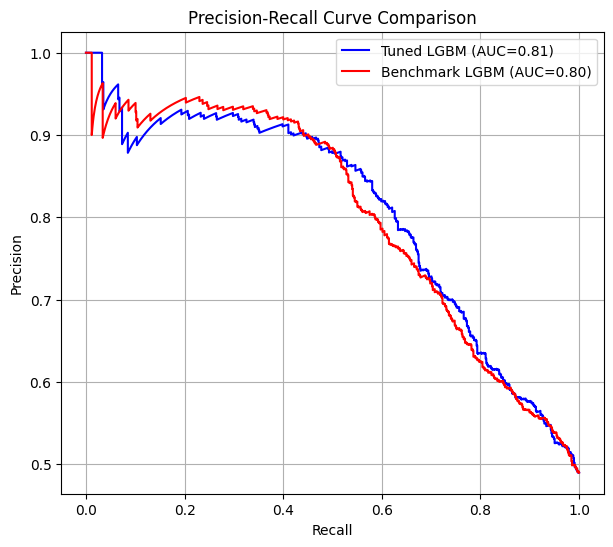

In [69]:
# PR curve
precision_t, recall_t, _ = precision_recall_curve(y_test, y_probs_tuned)
precision_b, recall_b, _ = precision_recall_curve(y_test, y_probs_bench)

pr_auc_t = auc(recall_t, precision_t)
pr_auc_b = auc(recall_b, precision_b)

plt.figure(figsize=(7,6))
plt.plot(recall_t, precision_t, label=f'Tuned LGBM (AUC={pr_auc_t:.2f})', color='blue')
plt.plot(recall_b, precision_b, label=f'Benchmark LGBM (AUC={pr_auc_b:.2f})', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Model Checking

## Confusion Matrix

In [70]:
y_test_pred_base = pipeLgm.predict(X_test)

In [71]:
y_test_pred_tuned = pipe_tuned.predict(X_test)

In [72]:
#calculate confusion matrix
conf_matrix_base = confusion_matrix(y_test, y_test_pred_base)
conf_matrix_tuned = confusion_matrix(y_test, y_test_pred_tuned)

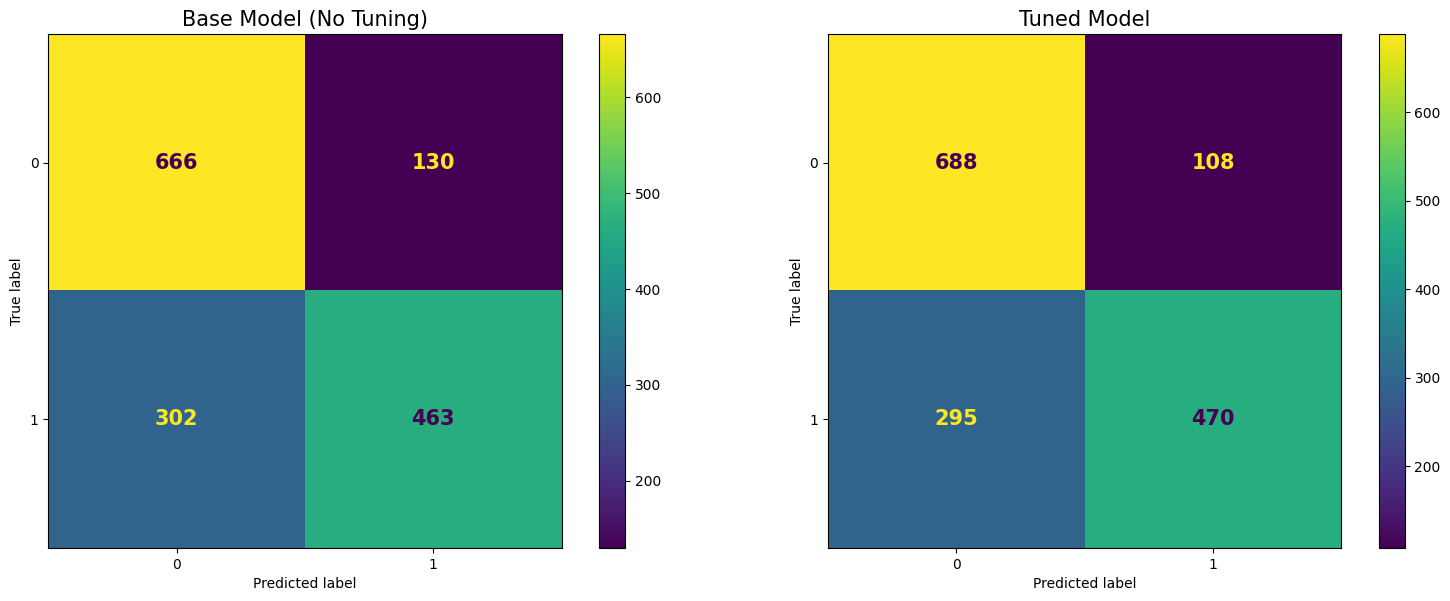

In [73]:
# Visualize confusion matrices
figure, axes = plt.subplots(ncols=2, figsize=(16, 6))

text_format = {'size': 15, 'weight': 'bold'}

ConfusionMatrixDisplay(conf_matrix_base).plot(ax=axes[0], text_kw=text_format)
axes[0].set_title('Base Model (No Tuning)', fontsize=15)

ConfusionMatrixDisplay(conf_matrix_tuned).plot(ax=axes[1], text_kw=text_format)
axes[1].set_title('Tuned Model', fontsize=15)

plt.tight_layout()
plt.show()

**Insight**
- Base Model:
    - True Positive (TP): 463
    - False Negative (FN): 302
    - True Negative (TN): 666
    - False Positive (FP): 130
- Tuned Model menunjukkan perbaikan kecil:
    - TP meningkat dari 463 menjadi 470
    - FP menurun dari 130 menjadi 108
    - FN menurun dari 302 menjadi 295

### Cost Simulation
1. Tanpa model
    - 1561 panggilan x Rp100.000 = Rp156.100.000
    - Pendapatan: 765 × 300.000 = Rp229.500.000
    - Laba bersih: 229.500.000 − 156.100.000 = Rp73.400.000

2. Base model (TP=463, FP=130, TN=666, FN=302)
    - Panggilan = 463+130 = 593 => Biaya panggilan = 59.300.000
    - Keuntungan: 463 × 300.000 = Rp138.900.000
    - penghematan: 666 × 100.000 = Rp66.600.000
    - Kerugian FN = 302×250k = 45.300.000
    - Laba bersih = 138.900.000 − 59.300.000 − 45.300.000 = Rp34.300.000 dan ada penghematan Rp66.600.000

3. Tuned model (TP=470, FP=108, TN=666, FN=295)
    - Panggilan = 470+108 = 578 => Biaya panggilan = 57.800.000
    - Keuntungan: 470 × 300.000 = Rp141.000.000
    - Penghematan: 688 × 100.000 = Rp68.800.000
    - Kerugian FN = 295×250k = 44.250.000
    - Laba bersih = 141.000.000 − 57.800.000 − 44.250.000 = Rp38.950 dan ada penghematan Rp68.800.000

4. Kesimpulan
    - Walaupun mendapatkan keuntungan yang lebih sedikit, tetapi jika menggunakan model akan ada penghematan biaya dan effort dalam panggilan yang dilakukan oleh departemen telemarketing yang mana akan membuat kampanye semakin efisien. Dimana jumlah panggilannya saja hampir berbanding 3x lipat antara menggunakan model dan tidak.


## Classification report

In [74]:
print(classification_report(y_test, y_test_pred_base))

              precision    recall  f1-score   support

           0       0.69      0.84      0.76       796
           1       0.78      0.61      0.68       765

    accuracy                           0.72      1561
   macro avg       0.73      0.72      0.72      1561
weighted avg       0.73      0.72      0.72      1561



In [75]:
print(classification_report(y_test, y_test_tuned))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77       796
           1       0.81      0.61      0.70       765

    accuracy                           0.74      1561
   macro avg       0.76      0.74      0.74      1561
weighted avg       0.76      0.74      0.74      1561



accuracy dan skor f1 meningkat daripada base model, menandakan model lebih seimbang antara precision (0.81) dan recall (0.61).
Meskipun recall tidak meningkat, precision yang naik berarti model lebih yakin pada prediksi nasabah yang akan deposit, yang akan membuat efisiensi kampanye meningkat.

## Interpretasi Model

In [76]:
modelImpo = pipe_tuned.named_steps['model']
importances = modelImpo.feature_importances_
importances

array([702, 858, 301,  21,  54,  13,  14,  38,   0,   5,  21,  10,  19,
        15,  14,  17,  65,   0,  14,  26,  40,  46,  34,  14,  30,  34,
        73,  50,  81,  50,  56,  48,  18,   8,  66,  10,  93,   6,  52,
         0, 390], dtype=int32)

### Feature Importance

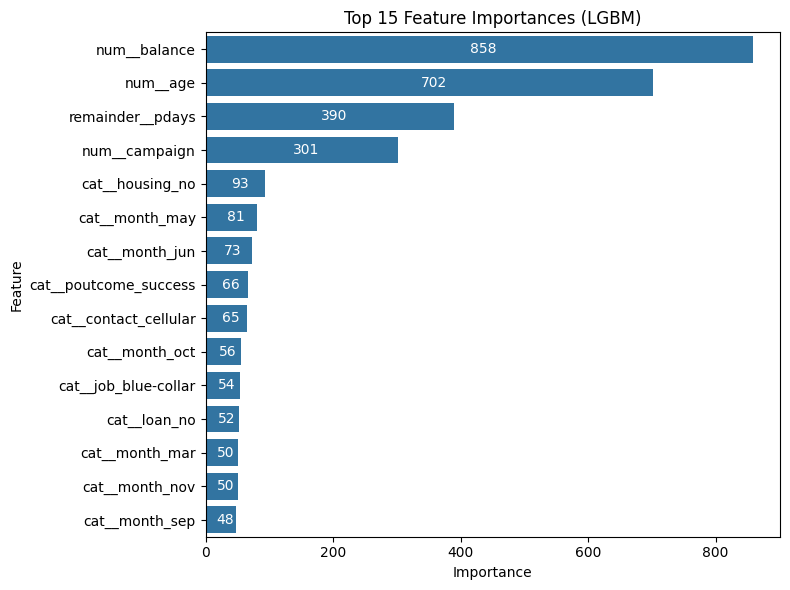

In [77]:
# Top 15 feature
featureNames = pipe_tuned.named_steps['preprocessor'].get_feature_names_out()

featImp = pd.DataFrame({
    'Feature': featureNames,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
ax = sns.barplot(x='Importance', y='Feature', data=featImp.head(15))

ax.bar_label(ax.containers[0], label_type='center', color='white', padding=3)

plt.title('Top 15 Feature Importances (LGBM)')
plt.tight_layout()
plt.show()

#### Insight
- num_balance merupakan fitur paling penting, saldo nasabah sangat menentukan probabilitas untuk melakukan deposit.
- num_age. Usia memberi sinyal kuat terkait kecenderungan finansial dan respons kampanye yang membuatnya menjadi salah satu fitur terpenting.
- remainder_pdays. Riwayat kontak sebelumnya sangat memengaruhi respons nasabah.
- num_campaign. Semakin sering dihubungi, semakin terlihat pola respon nasabah.
- Fitur kategori (housing, month, job) memiliki pengaruh namun lebih kecil, membantu model memahami konteks nasabah.

### SHAP Summary

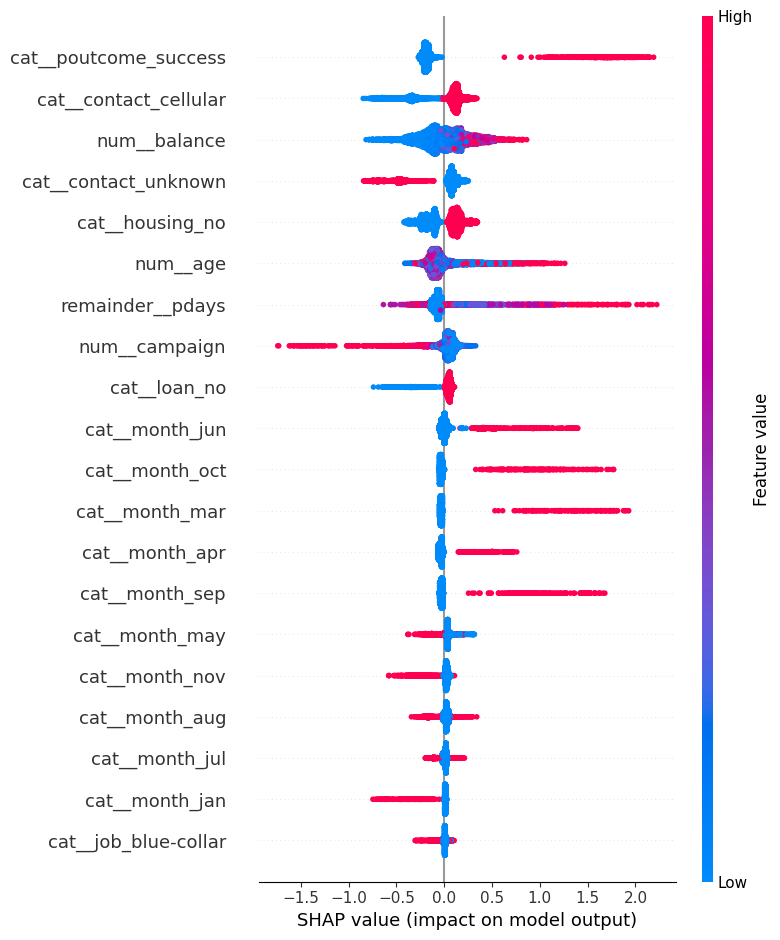

In [78]:
# Membuat SHAP Summary plot
model_final = pipe_tuned.named_steps['model']
X_train_preprocessed = pipe_tuned.named_steps['preprocessor'].transform(X_train)

explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(X_train_preprocessed)

# summary plot
shap.summary_plot(shap_values, X_train_preprocessed, feature_names=pipe_tuned.named_steps['preprocessor'].get_feature_names_out())

**cara membaca:**

**1. Ranking fitur berdasarkan seberapa besar pengaruhnya terhadap prediksi**

**2. Arah pengaruh fitur => mendorong ke Deposit (positif) atau No Deposit (negatif)**

**3. Warna Merah = nilai tinggi, warna Biru = nilai rendah**

**4. Semakin kanan arahnya, fitur mendorong ke Deposit**

**5. Semakin kiri arahnya, mendorong ke Tidak deposit**

#### Summary Insight
1. Faktor terkuat berasal dari riwayat kampanye
    - poutcome_success merupakan indikator paling kuat pelanggan akan deposit.

2. Cara komunikasi sangat berpengaruh
    - Kontak via cellular jauh lebih efektif daripada telephone/unknown.

3. Campaign fatigue itu nyata
    - num__campaign merah (banyak kontak) sangat mendorong prediksi “Tidak deposit” yang dimungkinkan karena jenuh dengan banyaknya jumlah campaign

4. ada perbedaan efektivitas panggilan berdasarkan bulan
    - bulan jun, may, nov menjadi bulan yang efektif melakukan panggilan

Pelanggan yang sudah memiliki riwayat sukses pada kampanye sebelumnya, dihubungi melalui cellular, dan tidak terlalu sering dihubungi, memiliki probabilitas paling tinggi untuk melakukan deposit. Sementara itu, pelanggan yang dihubungi terlalu sering, belum pernah dihubungi sebelumnya, atau kontaknya tidak jelas (unknown), memiliki peluang rendah untuk deposit.

In [79]:
# The X feature
X_test.iloc[[0,1,4,6,10,15]]

age         job  balance housing loan    contact month  campaign  pdays  \
2149  30   admin       315      yes     no   cellular   may   3         346     
2263  59   retired     434      yes     no   unknown    may   3        -1       
6523  54   technician  2102     yes     no   cellular   apr   1         626     
101   48   management  0        no      yes  cellular   feb   8        -1       
4771  77   retired     4112     no      no   telephone  jul   1         184     
543   40   management  754      no      yes  cellular   apr   1        -1       

     poutcome  
2149  failure  
2263  unknown  
6523  failure  
101   unknown  
4771  success  
543   unknown

In [80]:
y_test.iloc[[0,1,4,6,10,15]]

2149    1
2263    0
6523    1
101     0
4771    1
543     1
Name: deposit, dtype: int64

In [81]:
X_test.iloc[[0]]

age    job  balance housing loan   contact month  campaign  pdays  \
2149  30   admin  315      yes     no   cellular  may   3         346     

     poutcome  
2149  failure

In [82]:
y_test.iloc[[0]]

2149    1
Name: deposit, dtype: int64

In [83]:
def shap_plot(j, pipe, S):

    preprocessor = pipe.named_steps['preprocessor']
    model = pipe.named_steps['model']

    S_trans = preprocessor.transform(S)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(S_trans)

    pred = model.predict(S_trans)
    prob = model.predict_proba(S_trans)[j][1]

    print("=== SHAP Explanation Report ===")
    print(f"Data index ke-{j}")
    print(f"Prediksi model : {'Deposit' if pred[j] == 1 else 'Tidak Deposit'}")
    print(f"Probabilitas deposit : {prob:.4f}")

    shap.initjs()
    return shap.force_plot(
        base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        shap_values = shap_values[1][j] if isinstance(shap_values, list) else shap_values[j],
        features = S_trans.iloc[j],
        feature_names = S_trans.columns
    )

In [84]:
shap_plot(0, pipe_tuned, X_test)

=== SHAP Explanation Report ===
Data index ke-0
Prediksi model : Tidak Deposit
Probabilitas deposit : 0.4270


In [85]:
shap_plot(1, pipe_tuned, X_test)

=== SHAP Explanation Report ===
Data index ke-1
Prediksi model : Tidak Deposit
Probabilitas deposit : 0.2222


In [86]:
shap_plot(4, pipe_tuned, X_test)

=== SHAP Explanation Report ===
Data index ke-4
Prediksi model : Deposit
Probabilitas deposit : 0.7773


In [87]:
shap_plot(6, pipe_tuned, X_test)

=== SHAP Explanation Report ===
Data index ke-6
Prediksi model : Tidak Deposit
Probabilitas deposit : 0.1216


In [88]:
shap_plot(10, pipe_tuned, X_test)

=== SHAP Explanation Report ===
Data index ke-10
Prediksi model : Deposit
Probabilitas deposit : 0.9432


In [89]:
shap_plot(15, pipe_tuned, X_test)

=== SHAP Explanation Report ===
Data index ke-15
Prediksi model : Tidak Deposit
Probabilitas deposit : 0.4933


# Kesimpulan dan saran

## Kesimpulan
1. Kesimpulan Teknikal
    - Model LGBM dengan hyperparameter tuning memberikan performa terbaik dengan F1 Test = 0.70 dan PR-AUC = 0.81.
    - Tuning meningkatkan keseimbangan precision dan recall tanpa menyebabkan overfitting.
    - Berdasarkan evaluasi confusion matrix, model mampu mengurangi panggilan salah target (FP) dan menambah panggilan yang tepat (TP).
    - Model ini cocok untuk digunakan pada data kampanye aktual karena performanya stabil dan generalisasi baik.

2. Kesimpulan Finansial
    - Model LGBM menghasilkan efisiensi biaya dan tenaga dengan tetap mempertahankan efektivitas prediksi tinggi.
    - Dalam jangka panjang, penerapan model serupa pada skala ribuan kampanye dapat menghemat tenaga dan biaya kampanye per tahun dan meningkatkan ROI marketing.

## Saran
- Gunakan probabilitas model untuk membuat ranking calon nasabah. Misalnya, hubungi nasabah dengan probabilitas > 0.6 terlebih dahulu.
- Lakukan retraining berkala setiap 3–6 bulan untuk menyesuaikan dengan pola data nasabah terbaru.
- Analisis feature importance dari model untuk mengetahui faktor utama yang mempengaruhi keputusan nasabah.
- Bila ingin menurunkan risiko kehilangan calon nasabah potensial, pertimbangkan penyesuaian threshold untuk meningkatkan recall.

# Save file

## Save data yang sudah dibersihkan

In [90]:
# Save file format CSV
df.to_csv('Cleaned_data_bank_marketing_campaign.csv', index=False)

In [91]:
X.to_csv('Data for model test.csv', index=False)

## Save model ke SAV file

In [92]:
filename = 'model_lgbm_tuned.sav'
pickle.dump(pipe_tuned, open(filename, 'wb'))

## Load file SAV untuk mencoba

In [93]:
loadedModel = pickle.load(open('model_lgbm_tuned.sav', 'rb'))

# Tes prediksi
tesMod = loadedModel.predict(X)
tesMod

array([1, 0, 1, ..., 0, 0, 1])

## Cek 5 data teratas

In [94]:
print(tesMod[:5])

[1 0 1 0 0]


In [95]:
y.head()

0    1
1    1
2    1
3    0
4    0
Name: deposit, dtype: int64